## EfficientNetB0

- https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

### Configration

In [1]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [29]:
import os, gc

import numpy as np
import polars as pl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

TensorFlow version = 2.12.0


In [3]:
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 1 GPU


2024-02-24 03:05:03.158460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 03:05:03.259207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 03:05:03.259437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
SPEC_FILE_PATH = os.path.join(BASE_PATH, "train_spectrograms")
EEG_FILE_PATH = os.path.join(BASE_PATH, "train_eegs")

class CFG:
  VER = 1
  # LOAD_MODELS_FROM = "/kaggle/input/brain-efficientnet-models-v3-v4-v5"
  LOAD_MODELS_FROM = None

  MIX = True # 混合精度を入れるか
  # training params
  LR_START = 1e-4
  LR_MAX = 1e-3
  LR_RAMPUP_EPOCHS = 0
  LR_SUSTAIN_EPOCHS = 1
  LR_STEP_DECAY = 0.1
  EVERY = 1
  EPOCHS = 4


In [5]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if CFG.MIX:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


### Load train csv

In [6]:
train_df = pl.read_csv(os.path.join(BASE_PATH, "train.csv"))
label_columns = train_df.columns[-6:]

print("Train shape: ", train_df.shape)
print("label columns: ", list(label_columns))
train_df.head()

Train shape:  (106800, 15)
label columns:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


#### Create Non-Overlapping eeg_id train data

In [7]:
agg_columns = [
  pl.col("spectrogram_id").first().alias("spec_id"),
  pl.col("spectrogram_label_offset_seconds").min().alias("min"),
  pl.col("spectrogram_label_offset_seconds").max().alias("max"),
  pl.col("patient_id").first().alias("patient_id"),
]
agg_columns += [pl.col(v).sum().alias(v) for v in label_columns] # 後で割合を出す

processed_train_df = train_df.group_by("eeg_id").agg(agg_columns)

# label_columnsそれぞれの割合を出す
label_data = processed_train_df.select(label_columns).to_numpy()
label_data = label_data / label_data.sum(axis=1, keepdims=True)

processed_train_df[label_columns] = label_data

# label
tmp_df = train_df.group_by("eeg_id").agg(pl.col("expert_consensus").first().alias("label"))
processed_train_df = processed_train_df.join(tmp_df, on="eeg_id", how="left")

print("Train non-overlap eeg_id shape: ", processed_train_df.shape)
processed_train_df.head()

Train non-overlap eeg_id shape:  (17089, 12)


eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,label
i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
3281569856,1944449522,0.0,0.0,23828,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
21498048,1686467936,0.0,0.0,16947,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
1625882480,28392444,124.0,124.0,24273,0.0,0.142857,0.071429,0.0,0.071429,0.714286,"""Other"""
124612720,181962662,0.0,26.0,34298,0.0,0.454545,0.0,0.272727,0.090909,0.181818,"""LPD"""
342131552,765753086,2556.0,2556.0,31343,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""


### Load train spectrograms

In [8]:
%%time
files = os.listdir(SPEC_FILE_PATH)
print(f"There are {len(files)} spectrogram parquets")

specs = {}
for i, v in enumerate(files):
  tmp_df = pl.read_parquet(os.path.join(SPEC_FILE_PATH, v))
  name = int(v.split('.')[0])

  specs[name] = tmp_df.drop("time").to_numpy()

print(specs[355932412])

There are 11138 spectrogram parquets


[[1.745e+01 2.443e+01 4.322e+01 ... 5.000e-02 6.000e-02 6.000e-02]
 [2.023e+01 2.412e+01 3.494e+01 ... 2.000e-02 2.000e-02 2.000e-02]
 [1.380e+01 1.441e+01 2.312e+01 ... 3.000e-02 4.000e-02 3.000e-02]
 ...
 [1.217e+01 1.056e+01 1.605e+01 ... 3.000e-02 4.000e-02 4.000e-02]
 [2.046e+01 2.354e+01 3.197e+01 ... 3.000e-02 7.000e-02 4.000e-02]
 [3.894e+01 4.162e+01 4.446e+01 ... 3.000e-02 5.000e-02 5.000e-02]]
CPU times: user 3min 48s, sys: 1min 19s, total: 5min 8s
Wall time: 44.1 s


### Load train eeg

In [9]:
%%time
eegs = {}
for i, v in enumerate(processed_train_df.select("eeg_id").to_numpy().flatten()):
  tmp_df = pl.read_parquet(os.path.join(EEG_FILE_PATH, f"{v}.parquet"))

  eegs[v] = tmp_df.to_numpy()

print(eegs[1954249952])

[[-26.21 -45.97 -41.32 ...  83.56  91.09  25.4 ]
 [-14.54 -24.99 -22.79 ... 105.72 111.38  20.99]
 [-16.72 -30.2  -27.19 ...  96.84 104.32   7.76]
 ...
 [ 56.88  23.25 -15.22 ... -47.74 -47.56  33.06]
 [ 62.64  30.21  -8.   ... -35.95 -36.98  18.16]
 [ 45.13   3.59 -29.06 ... -62.91 -61.19  -0.75]]
CPU times: user 6min 3s, sys: 3min 20s, total: 9min 24s
Wall time: 40.3 s


### DataLoader

In [10]:
processed_train_df = processed_train_df.to_pandas()

In [47]:
from src.loaders import DataLoader

train_loader = DataLoader(
  df=processed_train_df,
  specs=specs,
  eegs=eegs,
  label_columns=label_columns,
  batch_size=32,
  shuffle=False,
)

In [12]:
train_loader.__getitem__(0)

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.

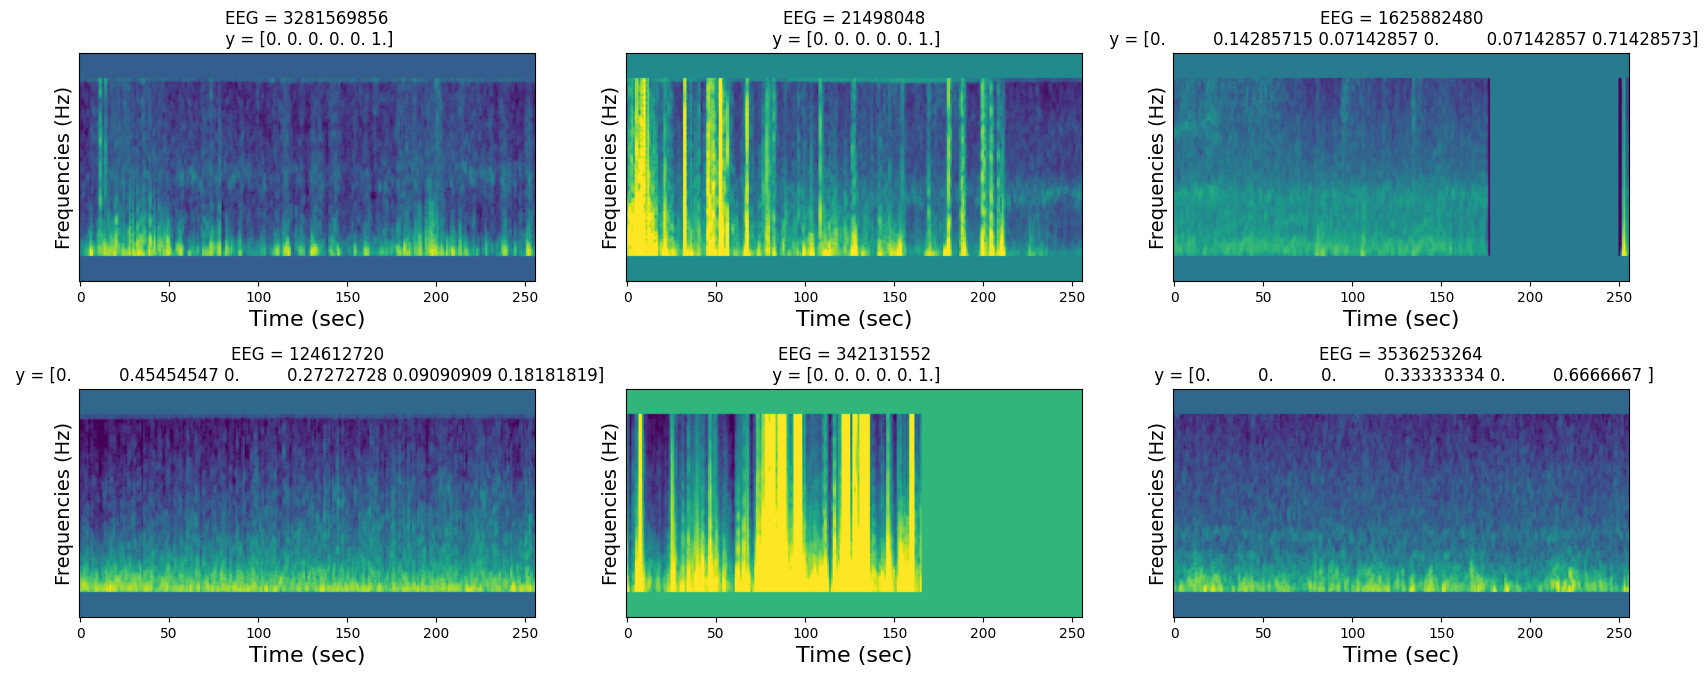

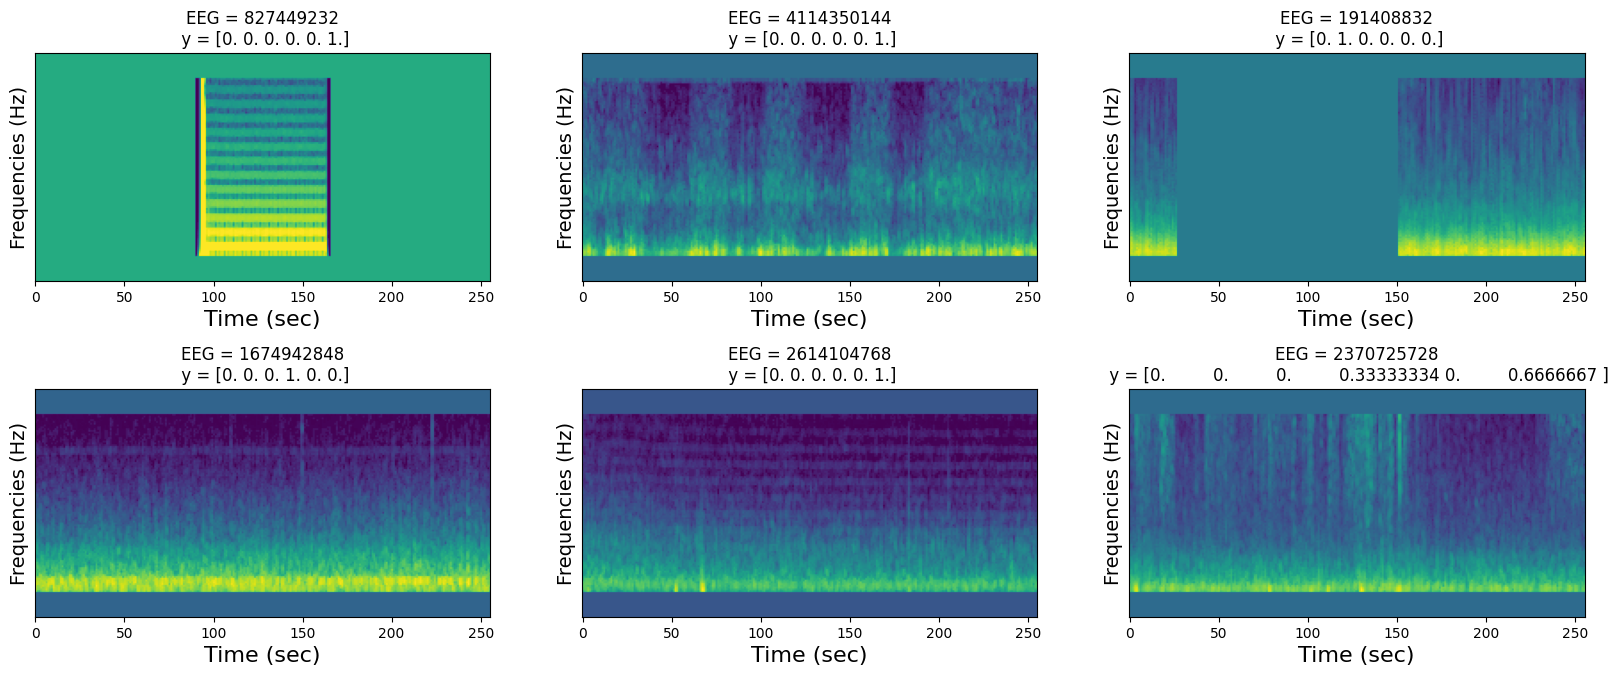

In [14]:
# dataloaderのスペクトログラム画像を表示

ROWS = 2
COLS = 3
BATCHES = 2

for i, (X, y) in enumerate(train_loader):
  plt.figure(figsize=(20,8))
  for j in range(ROWS):
    for k in range(COLS):
      plt.subplot(ROWS, COLS, j*COLS+k+1)

      img = X[j*COLS+k, :, :, 0][::-1,]

      min_value = img.flatten().min()
      max_value = img.flatten().max()
      img = (img-max_value) / (max_value-min_value)

      plt.imshow(img)

      y_s= y[j*COLS+k]

      y_texts = f"[{y_s[0]:0.2f}"
      for v in y_s[1:]:
        y_texts += f", {v:0.2f}"

      eeg = processed_train_df["eeg_id"].values[i*32+j*COLS+k]

      plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
      plt.yticks([])
      plt.ylabel("Frequencies (Hz)", size=14)
      plt.xlabel("Time (sec)", size=16)

  plt.show()

  if i == (BATCHES -1):
    break




### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

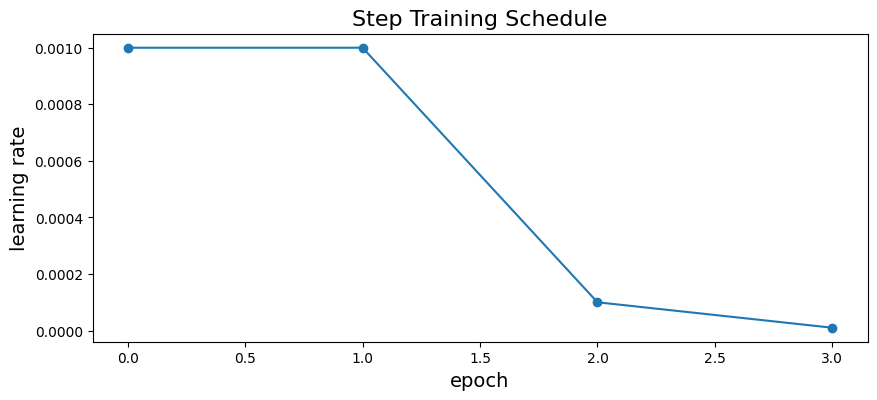

In [15]:
import math

def lrfn(epoch):
  if epoch < CFG.LR_RAMPUP_EPOCHS:
    lr = (CFG.LR_MAX - CFG.LR_START) / CFG.LR_RAMPUP_EPOCHS * epoch + CFG.LR_START
  elif epoch < (CFG.LR_RAMPUP_EPOCHS + CFG.LR_SUSTAIN_EPOCHS):
    lr = CFG.LR_MAX
  else:
    lr = CFG.LR_MAX * CFG.LR_STEP_DECAY ** ((epoch - CFG.LR_RAMPUP_EPOCHS - CFG.LR_SUSTAIN_EPOCHS) // CFG.EVERY)

  return lr

rng = [i for i in range(CFG.EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


In [16]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [18]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

from src.models import EfficientNetB0

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(gkf.split(processed_train_df, processed_train_df["label"], processed_train_df["patient_id"])):
  print(f"Fold {i+1}")

  train_loader = DataLoader(
    df=processed_train_df.iloc[train_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=32,
    shuffle=True,
    augment=False,
  )
  valid_loader = DataLoader(
    df=processed_train_df.iloc[valid_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=64,
    shuffle=False,
    mode="valid",
  )

  print(f"train size {len(train_ix)}, valid size {len(valid_ix)}")

  K.clear_session()

  with strategy.scope():
    model = EfficientNetB0.build_model()

  if CFG.LOAD_MODELS_FROM is None:
    model.fit(
      train_loader,
      verbose=1,
      validation_data=valid_loader,
      epochs=CFG.EPOCHS,
      callbacks=[LR],
    )

    model.save_weights(f"/kaggle/output/EfficientNet_v{CFG.VER}_f{i}.h5")
  else:
    model.load_weights(f"{CFG.LOAD_MODELS_FROM}/Efficient_v{CFG.VER}_f{i}.h5")

  oof = model.predict(valid_loader, verbose=1)

  all_oof.append(oof)
  all_true.append(processed_train_df.iloc[valid_ix][label_columns].values)

  del model, oof
  gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

Fold 1
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-02-24 03:17:47.884506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:17:47.884824: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:99"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

428/428 [==============================] - ETA: 0s - loss: 0.7645

2024-02-24 03:19:19.892647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:19:19.892976: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:115"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 98s 195ms/step - loss: 0.7645 - val_loss: 1.3372 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-02-24 03:19:26.113509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:19:26.113919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5875

2024-02-24 03:20:43.511958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:20:43.512041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:20:43.538353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:20:43.53

428/428 [==============================] - 83s 194ms/step - loss: 0.5875 - val_loss: 0.9784 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-02-24 03:20:49.279641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:20:49.279922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4533

2024-02-24 03:22:06.701177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:22:06.701267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:22:06.728464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:22:06.72

428/428 [==============================] - 83s 194ms/step - loss: 0.4533 - val_loss: 0.6953 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-02-24 03:22:12.472288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:22:12.472607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4046

2024-02-24 03:23:29.899103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:23:29.899194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:23:29.926212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:23:29.92

428/428 [==============================] - 83s 194ms/step - loss: 0.4046 - val_loss: 0.7148 - lr: 1.0000e-05


2024-02-24 03:23:35.961296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:23:35.961625: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:182"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 6s 107ms/step
Fold 2
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-02-24 03:23:43.508545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:23:43.508840: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:198"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.7589

2024-02-24 03:25:15.667030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:25:15.667352: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:214"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 98s 195ms/step - loss: 0.7589 - val_loss: 1.8325 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-02-24 03:25:21.887174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:25:21.887540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5971

2024-02-24 03:26:39.142782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:26:39.142861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:26:39.169704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:26:39.16

428/428 [==============================] - 83s 194ms/step - loss: 0.5971 - val_loss: 0.7961 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-02-24 03:26:44.937692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:26:44.937903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4534

2024-02-24 03:28:02.332206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:28:02.332290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:28:02.358681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:28:02.35

428/428 [==============================] - 83s 194ms/step - loss: 0.4534 - val_loss: 0.6705 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-02-24 03:28:08.124016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:28:08.124380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4055

2024-02-24 03:29:25.274579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:29:25.274658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:29:25.300274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:29:25.30

428/428 [==============================] - 83s 194ms/step - loss: 0.4055 - val_loss: 0.6770 - lr: 1.0000e-05


2024-02-24 03:29:31.301824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:29:31.302175: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:281"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 6s 106ms/step
Fold 3
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-02-24 03:29:38.807640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:29:38.807991: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:297"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.7647

2024-02-24 03:31:10.965887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:31:10.966193: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:313"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 98s 195ms/step - loss: 0.7647 - val_loss: 0.8446 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-02-24 03:31:17.160099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:31:17.160377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5866

2024-02-24 03:32:34.387293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:32:34.387373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:32:34.413842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:32:34.41

428/428 [==============================] - 83s 194ms/step - loss: 0.5866 - val_loss: 0.8045 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-02-24 03:32:40.192405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:32:40.192484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4519

2024-02-24 03:33:57.527287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:33:57.527370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:33:57.552733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:33:57.55

428/428 [==============================] - 83s 194ms/step - loss: 0.4519 - val_loss: 0.6220 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-02-24 03:34:03.315536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:34:03.315903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4053

2024-02-24 03:35:20.561560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:35:20.561643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:35:20.587591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:35:20.58

428/428 [==============================] - 83s 194ms/step - loss: 0.4053 - val_loss: 0.6137 - lr: 1.0000e-05


2024-02-24 03:35:26.588296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:35:26.588642: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:380"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 6s 106ms/step
Fold 4
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-02-24 03:35:34.060711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:35:34.061045: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:396"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.7628

2024-02-24 03:37:06.462225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:37:06.462559: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:412"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 99s 195ms/step - loss: 0.7628 - val_loss: 0.9096 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-02-24 03:37:12.668369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:37:12.668736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5823

2024-02-24 03:38:30.044103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:38:30.044205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:38:30.071263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:38:30.07

428/428 [==============================] - 83s 194ms/step - loss: 0.5823 - val_loss: 0.9156 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-02-24 03:38:35.838798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:38:35.839168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4504

2024-02-24 03:39:53.213490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:39:53.213577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:39:53.239690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:39:53.23

428/428 [==============================] - 83s 194ms/step - loss: 0.4504 - val_loss: 0.6517 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-02-24 03:39:58.968921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:39:58.969563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4030

2024-02-24 03:41:16.377001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:41:16.377081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:41:16.404029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:41:16.40

428/428 [==============================] - 83s 194ms/step - loss: 0.4030 - val_loss: 0.6517 - lr: 1.0000e-05


2024-02-24 03:41:22.423353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:41:22.423709: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:479"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 6s 107ms/step
Fold 5
train size 13672, valid size 3417

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-02-24 03:41:29.960407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:41:29.960756: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:495"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.7723

2024-02-24 03:43:03.252492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:43:03.252812: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:511"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 100s 198ms/step - loss: 0.7723 - val_loss: 0.9248 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-02-24 03:43:09.697080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:43:09.697163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5986

2024-02-24 03:44:27.364478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:44:27.364557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:44:27.391153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:44:27.39

428/428 [==============================] - 83s 195ms/step - loss: 0.5986 - val_loss: 0.7666 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-02-24 03:44:33.132224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:44:33.132723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4561

2024-02-24 03:45:50.766709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:45:50.766792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:45:50.792207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:45:50.79

428/428 [==============================] - 83s 195ms/step - loss: 0.4561 - val_loss: 0.6482 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-02-24 03:45:56.536098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:45:56.536397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4104

2024-02-24 03:47:14.303217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:47:14.303301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:47:14.329532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:47:14.32

428/428 [==============================] - 84s 195ms/step - loss: 0.4104 - val_loss: 0.6451 - lr: 1.0000e-05


2024-02-24 03:47:20.356118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-24 03:47:20.356460: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:578"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 6s 106ms/step


### CV score for EfficientNet

KL(=Kullback-Leibler) Divergenceによる性能評価
https://qiita.com/shuva/items/81ad2a337175c035988f

In [48]:
from src.metrics import kl_div

oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

cv = kl_div.score(solution=true, submission=oof, row_id_column_name="id")

print("CV score KL-Div for EfficientNetB2=", cv)

CV score KL-Div for EfficientNetB2= 0.6604485085182042
